# Model Comparison and Feature Importance

In this notebook, I will:
1. Compare multiple machine learning algorithms beyond Logistic Regression, such as Random Forest and XGBoost, to see if I can improve predictive performance.
2. Implement basic hyperparameter tuning (e.g., using `GridSearchCV`) to optimize model settings.
3. Evaluate models using metrics crucial for credit risk analysis, such as AUC-ROC and Precision-Recall, since identifying "bad" credit risks can be more important than overall accuracy.
4. Explore feature importance and model interpretability. Understanding which features influence the model’s decisions is vital in credit risk contexts, where explainability and compliance are often required.

By the end of this notebook, I hope to identify a model that outperforms the initial baselines and to have a better understanding of what drives predictions, setting the stage for a final, interpretable, and reliable credit risk model.

In [39]:
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier

# Load the data
X_train = joblib.load("../data/X_train.pkl")
X_test = joblib.load("../data/X_test.pkl")
y_train = joblib.load("../data/y_train.pkl")
y_test = joblib.load("../data/y_test.pkl")

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (800, 48)
X_test shape: (200, 48)
y_train shape: (800,)
y_test shape: (200,)


### Random Forest Baseline

I'll train a basic Random Forest with default parameters and compare its performance to the Logistic Regression baseline. Random Forests are often good at handling complex interactions between features and may provide better recall for the "bad" class.

In [4]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]) # Calculate AUC
print("Random Forest Accuracy:", acc_rf)
print("Random Forest AUC:", auc_rf)

print("\nClassificaction Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.745
Random Forest AUC: 0.7909604519774011

Classificaction Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.83       141
           1       0.62      0.34      0.44        59

    accuracy                           0.74       200
   macro avg       0.70      0.63      0.64       200
weighted avg       0.73      0.74      0.72       200



The Random Forest's accuracy and AUC provide a quick snapshot. If the AUC is higher than Logistic Regression’s AUC, it suggests the Random Forest may be better at ranking which customers are more likely to be bad credit risks. I will pay special attention to the recall for the bad class and the AUC-ROC, as these metrics align better with credit risk priorities.

**Interpretation (Random Forest Baseline):**

- **Accuracy (~0.745)**: Slightly lower than the improved Logistic Regression (~0.795).
- **AUC (~0.79)**: Decent ranking ability, but I need to check recall for the bad class.
- **Bad Credit Recall (~0.34)**: Lower than Logistic Regression’s ~0.59, meaning it misses most bad credit customers.

This baseline Random Forest isn't outperforming Logistic Regression at identifying high-risk clients. I may need hyperparameter tuning.

### Hyperparameter Tuning for Random Forest

I will try a simple grid search to see if adjusting parameters (like `max_depth`, `n_estimators`, `min_samples_leaf`) can improve the model’s AUC and recall for the bad class.

In [43]:
param_grid = {
    'n_estimators': [100,300],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 5]
}

grid_search = GridSearchCV(
    estimator = RandomForestClassifier(random_state=42),
    param_grid = param_grid,
    scoring = 'roc_auc',
    cv = 3,
    n_jobs = -1
)

grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)
print("Best Score (AUC):", grid_search.best_score_)

Best Params: {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 100}
Best Score (AUC): 0.7623129915833197


**Interpreting the Grid Search Results:**

- `n_estimators`: Number of trees in the forest. More trees can improve performance but increase training time.
- `max_depth`: Maximum depth of the trees. Deeper trees can model complex relationships but may overfit.
- `min_samples_leaf`: Minimum samples per leaf. Increasing this can reduce overfitting.

The best parameters found by GridSearchCV will be used to retrain the Random Forest and evaluate again.


In [10]:
best_rf = grid_search.best_estimator_ 
y_pred_best_rf = best_rf.predict(X_test)

acc_best_rf = accuracy_score(y_test, y_pred_best_rf)
auc_best_rf = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1])

print("Optimized Random Forest Accuracy:", acc_best_rf)
print("Optimized Random Forest AUC:", auc_best_rf)
print("\nClassification Report:\n", classification_report(y_test, y_pred_best_rf))

Optimized Random Forest Accuracy: 0.75
Optimized Random Forest AUC: 0.8015386464719317

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.96      0.84       141
           1       0.71      0.25      0.38        59

    accuracy                           0.75       200
   macro avg       0.73      0.61      0.61       200
weighted avg       0.74      0.75      0.71       200



**Interpretation (Optimized Random Forest):**

- **Accuracy (~0.75)**: Slight improvement.
- **AUC (~0.80)**: Slight improvement.
- **Bad Credit Recall (~0.25)**: Actually worse than the baseline (0.34).

While tuning improved overall metrics slightly, it reduced recall for bad credit even further, making it less suitable for credit risk detection. Let’s try another model.

### Trying XGBoost

XGBoost is known for strong performance on tabular data. I’ll try a basic XGBoost model to see if it can improve the balance of performance, particularly recall for bad credit customers.


In [13]:
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1])

print("XGBoost Accuracy:", acc_xgb)
print("XGBoost AUC:", auc_xgb)
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.785
XGBoost AUC: 0.8139199423007573

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85       141
           1       0.67      0.53      0.59        59

    accuracy                           0.79       200
   macro avg       0.75      0.71      0.72       200
weighted avg       0.78      0.79      0.78       200



C:\Users\SebastianGM\anaconda3\envs\pd_model_env\lib\site-packages\xgboost\core.py:158: UserWarning: [07:23:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


**Interpretation (XGBoost):**

- **Accuracy (~0.785)**: Better than the Random Forest models, slightly below the improved Logistic Regression.
- **AUC (~0.81)**: Higher than both Logistic Regression and Random Forest.
- **Bad Credit Recall (~0.53)**: Significantly better than Random Forest, on par with improved Logistic Regression.

XGBoost seems to offer a better balance: it catches more bad credit customers than Random Forest and ranks customers well (high AUC). This makes XGBoost a strong candidate moving foward.


## Feature Importance

I’ll examine feature importances from the Random Forest and XGBoost models. This helps confirm which features consistently matter most.

In [16]:
importances = best_rf.feature_importances_
feature_names = X_train.columns 

# Create a DataFrame with feature importances
feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

feat_imp_df.head(10)

,feature,importance
9,Status_of_existing_checking_account_A14,0.137842
1,Credit_amount,0.129003
4,Age_in_years,0.100649
0,Duration_in_month,0.097807
2,Installment_rate_in_percentage_of_disposable_i...,0.037479
13,Credit_history_A34,0.036118
3,Present_residence_since,0.033003
41,Housing_A152,0.030111
7,Status_of_existing_checking_account_A12,0.023187
40,Other_installment_plans_A143,0.022276


We see that certain features stand out. To make them more readable, I’ll map some original feature names to cleaner descriptions.


In [18]:
# Mapping original feature names to clean, readable names
clean_feature_names = {
    "Status_of_existing_checking_account_A14": "No Checking Account",
    "Credit_amount": "Credit Amount",
    "Age_in_years": "Age",
    "Duration_in_month": "Credit Duration",
    "Installment_rate_in_percentage_of_disposable_income": "Installment Rate",
    "Credit_history_A34": "Critical Credit History",
    "Present_residence_since": "Years at Residence",
    "Housing_A152": "Own Housing",
    "Status_of_existing_checking_account_A12": "Low Balance Checking",
    "Other_installment_plans_A143": "No Other Installment Plans"
}

# Replace feature names with clean names
feat_imp_df['feature'] = feat_imp_df['feature'].replace(clean_feature_names)

# Sort and display the top 10 features
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)
feat_imp_df.head(10)

,feature,importance
9,No Checking Account,0.137842
1,Credit Amount,0.129003
4,Age,0.100649
0,Credit Duration,0.097807
2,Installment Rate,0.037479
13,Critical Credit History,0.036118
3,Years at Residence,0.033003
41,Own Housing,0.030111
7,Low Balance Checking,0.023187
40,No Other Installment Plans,0.022276


### Feature Importance Analysis (Random Forest)

Top 10 features suggest:
- **No Checking Account** and **Credit Amount** are highly influential.
- **Age** and **Credit Duration** also matter significantly.
- Installment Rate and Credit History play a moderate role.

This aligns with the idea that lack of a checking account, larger loans, and certain demographic/credit history factors raise flags in credit risk assessment.

### Feature Importance Analysis (XGBoost)

Now, let’s look at the top features from the XGBoost model to see if similar patterns emerge.

In [69]:
xgb_importances = xgb.feature_importances_
xgb_feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': xgb_importances})
xgb_feat_imp_df['feature'] = xgb_feat_imp_df['feature'].replace(clean_feature_names)
xgb_feat_imp_df = xgb_feat_imp_df.sort_values('importance', ascending=False)
xgb_feat_imp_df.head(10)

,feature,importance
9,No Checking Account,0.102722
35,Other_debtors_or_guarantors_A103,0.067574
8,Status_of_existing_checking_account_A13,0.038816
25,Savings_account_bonds_A64,0.032750
38,Property_A124,0.031116
26,Savings_account_bonds_A65,0.030579
19,Purpose_A45,0.029664
13,Critical Credit History,0.028660
29,Present_employment_since_A74,0.027591
40,No Other Installment Plans,0.026665


**XGBoost Key Observations:**
- **No Checking Account** remains top, consistent across models.
- XGBoost also emphasizes guarantors and savings-related features slightly more than Random Forest.
- This indicates both models agree on certain key factors but differ in how much they weight others.

These differences highlight that while some features (e.g., No Checking Account) are universally important, model choice can affect how other variables are interpreted.


### SHAP: Enhancing Feature Interpretability

To complement the feature importance analysis, I will use **SHAP (SHapley Additive exPlanations)** to understand how each feature contributes to individual predictions. This provides:
1. **Global Importance**: Which features matter most across all predictions.
2. **Local Importance**: How specific features influence individual decisions.

In credit risk contexts, such transparency is valuable for regulatory compliance and stakeholder rust.


#### Ensuring Numeric Data for SHAP

SHAP requires that all input features be numeric. Although I have no `object` or `category` types, I do see `bool` (boolean) columns. While boolean columns are numeric (0/1) under the hood, it's safer to convert them explicitly to floats. This step ensures there's no conflict when SHAP tries to interpret the data.

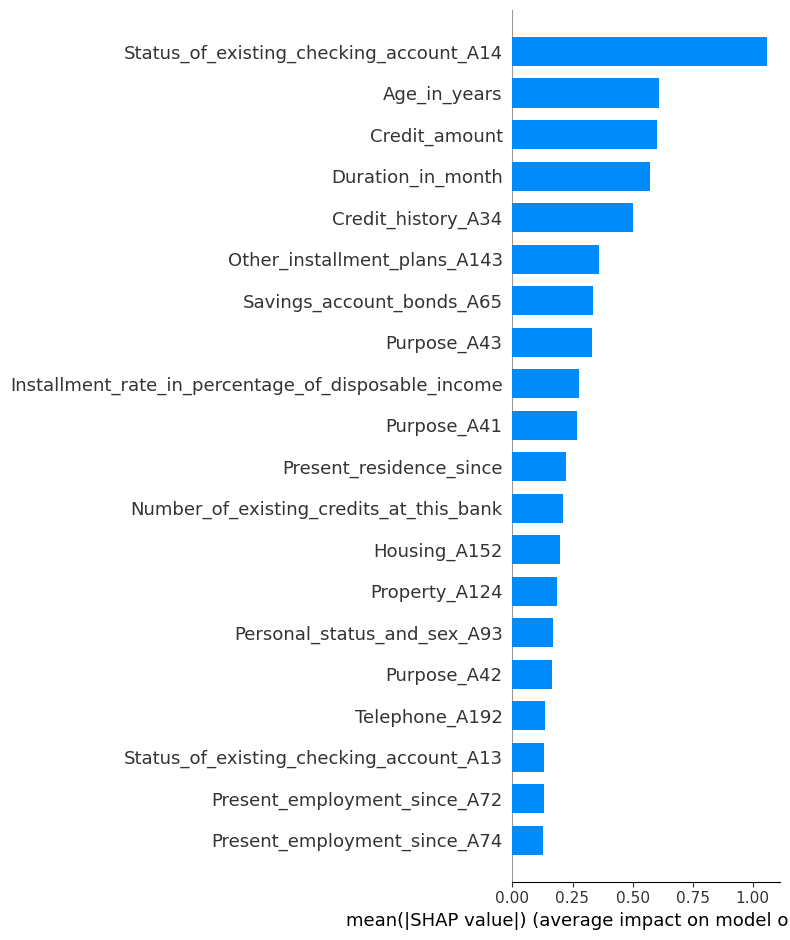

In [73]:
import shap

# Ensure all features are numeric floats (if any boolean remains)
X_train = X_train.astype(float)
X_test = X_test.astype(float)

explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

### Interpreting the SHAP Summary Plot

The SHAP summary plot confirms earlier insights:

- **No Checking Account** dominates the overall contribution.
- **Age, Credit Amount, and Credit Duration** also have high impact.
- Other features like Critical Credit History, Savings, and Purpose refine the model’s decisions for specific groups.

This matches our feature importance findings and provides a clearer, more transparent view of why the model ranks certain customers as higher or lower risk.

In [76]:
results = {
    'Model': ['Improved Logistic Regression', 'Optimized Random Forest', 'XGBoost (Baseline)'],
    'Accuracy': [0.795, 0.75, 0.785],
    'AUC': [0.80, 0.80, 0.8139],
    'Bad Credit Recall': [0.59, 0.25, 0.53]
}

results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,AUC,Bad Credit Recall
0,Improved Logistic Regression,0.795,0.8000,0.59
1,Optimized Random Forest,0.750,0.8000,0.25
2,XGBoost (Baseline),0.785,0.8139,0.53


### Final Conclusion

Throughout this project, I explored various models and techniques to predict credit risk. Starting with baseline models (Logistic Regression, Decision Tree) and progressing to more advanced methods (Random Forest, XGBoost), I aimed to improve key metrics—especially the recall for bad credit customers—since identifying high-risk clients is critical in a lending scenario.

**Key Findings:**
- **Improved Logistic Regression** struck a decent balance between overall accuracy and recall for the bad class.
- **Optimized Random Forest** improved AUC and accuracy slightly but struggled more with recall for bad credit customers.
- **XGBoost** offered a good compromise, delivering a high AUC and better recall for the bad class than Random Forest, making it a strong candidate for further refinement.

**Interpretability:**
- Feature importance and SHAP analyses consistently highlighted the absence of a checking account, credit amount, and certain demographic/loan-related factors as key drivers of the model’s decisions.
- This transparency is valuable, as it aligns the model with real-world lending practices and helps stakeholders trust the predictions.